In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Molsnapper
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Molsnapper

Read specific .sdf files with `*_shifted.sdf` pattern and convert them to a list of SMILES.

In [4]:
sdf_files = glob.glob('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Molsnapper/sample_MolDiff_20240913_151328_clash_rate_0.1_SDF/*_shifted.sdf')

In [5]:
# Initialize an empty list to store SMILES and file names
data = []

# Loop over each SDF file
for sdf_file in sdf_files:
    # Read the SDF file
    supplier = Chem.SDMolSupplier(sdf_file)
    
    # Extract SMILES from each molecule in the SDF file
    for mol in supplier:
        if mol is not None:  # Ensure the molecule is valid
            smiles = Chem.MolToSmiles(mol)
            # Append the SMILES and the filename to the data list
            data.append({"File Name": sdf_file, "SMILES": smiles})

### Make sure 1000 molecules are generated and calculated
data.pop(1000)
len(data)

1000

Convert SMILES and name of them to a dataframe

In [6]:
df = pd.DataFrame(data)
df

,File Name,SMILES
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1C1=C[N@+]2(C(=O)C(c3cc(Cl)cc(OC[C@@...
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(C2=C3C(=O)N(C4CNC[C@@H]5C[C@H]4...
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...
...,...,...
995,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3C#N)cn(C3C4C...
996,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(N2c3c(-c4ccc(C)cc4C#N)cn([C@]45...
997,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1-c1cc(-c2cc(Cl)cc(OCC3CC3)c2)c(=O)n...
998,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc2c1N2c1cc(-c2ccccc2C#N)cn(-c2ccc...


Add an RDKit molecule to the dataframe

In [7]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

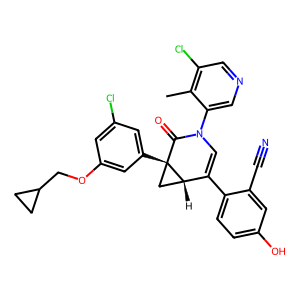

In [8]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0      [c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...
1      [c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...
2      [c1ccccc1, O=C1NCC=C2C=C12, C1C[C@H]2C[C@H]2CN...
3      [c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...
4      [c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...
                             ...                        
995    [c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CN2CC23C...
996    [c1ccccc1, O=c1[nH]ccc2c1N2, c1ccccc1, C1=CC2=...
997    [c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CC1, C1C...
998    [c1ccc2c(c1)N2, O=c1cccc[nH]1, c1ccccc1, c1ccn...
999    [c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...
Name: ring_sytems, Length: 1000, dtype: object

In [10]:
df.ring_sytems.values

array([list(['c1ccncc1', 'O=C1NC=C[C@@H]2C[C@H]12', 'c1ccccc1', 'c1ccccc1', 'C1CC1']),
       list(['c1ccccc1', 'O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312', 'c1ccccc1', 'C1COC1']),
       list(['c1ccccc1', 'O=C1NCC=C2C=C12', 'C1C[C@H]2C[C@H]2CN1', 'c1ccccc1']),
       list(['c1ccccc1', 'O=c1cc2c(c[nH]1)N2', 'C1C[C@H]2C[C@H]2CN1', 'c1ccccc1']),
       list(['c1ccccc1', 'O=c1cccc[nH]1', 'c1ccccc1', 'O=C1CCC[C@H]2CN12']),
       list(['c1ccccc1', 'O=c1cccc[nH]1', 'c1ccccc1', 'c1ccncc1']),
       list(['c1ccccc1', 'O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312', 'c1ccccc1']),
       list(['c1ccccc1', 'O=c1cccc[nH]1', 'c1ccccc1', 'c1ccncc1']),
       list(['c1ccccc1', 'O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312', 'c1ccccc1']),
       list(['c1ccccc1', 'O=C1C=C2[NH+]=C2CN1', 'c1ccccc1', 'c1ccncc1']),
       list(['c1ccccc1', 'O=c1cccc[nH]1', 'c1ccc2c(c1)N2', 'c1ccncc1']),
       list(['c1ccccc1', 'O=c1cccc[nH]1', 'c1ccccc1', 'c1ccncc1']),
       list(['c1ccccc1', 'O=C1C=CC=C[N@@+]12CC13C=C1C=N

See how many times each ring system occurs

In [11]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
2,c1ccccc1,1820
0,c1ccncc1,667
9,O=c1cccc[nH]1,547
3,C1CC1,156
23,C1CC2CC2CN1,74
...,...,...
94,C1C2[C@@H]1C1NC13C[C@@H]23,1
95,O=C1CCCC(=O)N1,1
82,O=C1C=C2[NH2+]C2C[N@@+]12[C@@H]1[C@H]3CC[NH2+]...,1
87,C1C2C[C@@H]3CN3C[C@H]12,1


View the ring system frequencies

In [12]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [13]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [14]:
res

0      [(c1ccncc1, 231698), (O=C1NC=C[C@@H]2C[C@H]12,...
1      [(c1ccccc1, 2260082), (O=C1C=CC=C[N@@+]12[C@@H...
2      [(c1ccccc1, 2260082), (O=C1NCC=C2C=C12, 0), (C...
3      [(c1ccccc1, 2260082), (O=c1cc2c(c[nH]1)N2, 0),...
4      [(c1ccccc1, 2260082), (O=c1cccc[nH]1, 11659), ...
                             ...                        
995    [(c1ccccc1, 2260082), (O=c1cccc[nH]1, 11659), ...
996    [(c1ccccc1, 2260082), (O=c1[nH]ccc2c1N2, 0), (...
997    [(c1ccccc1, 2260082), (O=c1cccc[nH]1, 11659), ...
998    [(c1ccc2c(c1)N2, 0), (O=c1cccc[nH]1, 11659), (...
999    [(c1ccccc1, 2260082), (O=C1C=CC=C[N@@+]12[C@@H...
Name: mol, Length: 1000, dtype: object

In [15]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1380>,"[c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...",O=C1NC=C[C@@H]2C[C@H]12,0
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1C1=C[N@+]2(C(=O)C(c3cc(Cl)cc(OC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e13f0>,"[c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...",O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312,0
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(C2=C3C(=O)N(C4CNC[C@@H]5C[C@H]4...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1460>,"[c1ccccc1, O=C1NCC=C2C=C12, C1C[C@H]2C[C@H]2CN...",O=C1NCC=C2C=C12,0
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e14d0>,"[c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...",O=c1cc2c(c[nH]1)N2,0
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1540>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...",O=C1CCC[C@H]2CN12,0
...,...,...,...,...,...,...
995,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3C#N)cn(C3C4C...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc9e0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CN2CC23C...",C1CN2CC23CC13,0
996,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(N2c3c(-c4ccc(C)cc4C#N)cn([C@]45...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fca50>,"[c1ccccc1, O=c1[nH]ccc2c1N2, c1ccccc1, C1=CC2=...",O=c1[nH]ccc2c1N2,0
997,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1-c1cc(-c2cc(Cl)cc(OCC3CC3)c2)c(=O)n...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fcac0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CC1, C1C...",C1CC2CC2CN1,21
998,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc2c1N2c1cc(-c2ccccc2C#N)cn(-c2ccc...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fcb30>,"[c1ccc2c(c1)N2, O=c1cccc[nH]1, c1ccccc1, c1ccn...",c1ccc2c(c1)N2,0


In [16]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [17]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Proton(s) added/removed

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Proton(s) added/removed

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefined stereo

[21:18:42] WARNING: Omitted undefine

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1380>,"[c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...",O=C1NC=C[C@@H]2C[C@H]12,0,InChI=1S/C29H23Cl2N3O3/c1-16-26(31)12-33-13-27...
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1C1=C[N@+]2(C(=O)C(c3cc(Cl)cc(OC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e13f0>,"[c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...",O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312,0,InChI=1S/C28H25ClN3O3/c29-20-9-18(10-22(12-20)...
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(C2=C3C(=O)N(C4CNC[C@@H]5C[C@H]4...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1460>,"[c1ccccc1, O=C1NCC=C2C=C12, C1C[C@H]2C[C@H]2CN...",O=C1NCC=C2C=C12,0,InChI=1S/C28H26ClN3O2/c1-2-7-34-20-9-17(8-19(2...
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e14d0>,"[c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...",O=c1cc2c(c[nH]1)N2,0,InChI=1S/C28H27ClN4O2/c1-3-8-35-20-10-18(9-19(...
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1540>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...",O=C1CCC[C@H]2CN12,0,InChI=1S/C27H24ClN3O3/c1-2-9-34-21-11-18(10-20...
...,...,...,...,...,...,...,...
721,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccc([...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc890>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccccc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H21ClN3O4/c1-2-10-35-24-12-19(11-2...
722,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)COc1cc(Cl)cc(C2=CC(=[N+]3c4cccc(C#N)c43)C...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc900>,"[c1ccccc1, O=C1C=CC(=[N+]2c3ccccc32)CN1, c1ccn...",O=C1C=CC(=[N+]2c3ccccc32)CN1,0,InChI=1S/C27H22ClN4O2/c1-17(2)16-34-23-10-19(9...
723,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CCOc1cc(Cl)cc(-c2cc(C34C=CC=CC3=C4C#N)cn(...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc970>,"[c1ccccc1, O=c1cccc[nH]1, C1=CC2=CC2C=C1, c1cc...",C1=CC2=CC2C=C1,0,InChI=1S/C28H23ClN4O2/c1-32(2)10-11-35-23-13-1...
724,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3C#N)cn(C3C4C...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc9e0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CN2CC23C...",C1CN2CC23CC13,0,InChI=1S/C27H23Cl2N3O2/c1-2-7-34-21-10-16(8-20...


How many of them have ring system?

In [18]:
df_ring = df[df.min_freq != -1]
df_ring

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1380>,"[c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...",O=C1NC=C[C@@H]2C[C@H]12,0,InChI=1S/C29H23Cl2N3O3/c1-16-26(31)12-33-13-27...
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1C1=C[N@+]2(C(=O)C(c3cc(Cl)cc(OC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e13f0>,"[c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...",O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312,0,InChI=1S/C28H25ClN3O3/c29-20-9-18(10-22(12-20)...
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(C2=C3C(=O)N(C4CNC[C@@H]5C[C@H]4...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1460>,"[c1ccccc1, O=C1NCC=C2C=C12, C1C[C@H]2C[C@H]2CN...",O=C1NCC=C2C=C12,0,InChI=1S/C28H26ClN3O2/c1-2-7-34-20-9-17(8-19(2...
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e14d0>,"[c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...",O=c1cc2c(c[nH]1)N2,0,InChI=1S/C28H27ClN4O2/c1-3-8-35-20-10-18(9-19(...
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9e1540>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...",O=C1CCC[C@H]2CN12,0,InChI=1S/C27H24ClN3O3/c1-2-9-34-21-11-18(10-20...
...,...,...,...,...,...,...,...
721,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccc([...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc890>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccccc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H21ClN3O4/c1-2-10-35-24-12-19(11-2...
722,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)COc1cc(Cl)cc(C2=CC(=[N+]3c4cccc(C#N)c43)C...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc900>,"[c1ccccc1, O=C1C=CC(=[N+]2c3ccccc32)CN1, c1ccn...",O=C1C=CC(=[N+]2c3ccccc32)CN1,0,InChI=1S/C27H22ClN4O2/c1-17(2)16-34-23-10-19(9...
723,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CCOc1cc(Cl)cc(-c2cc(C34C=CC=CC3=C4C#N)cn(...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc970>,"[c1ccccc1, O=c1cccc[nH]1, C1=CC2=CC2C=C1, c1cc...",C1=CC2=CC2C=C1,0,InChI=1S/C28H23ClN4O2/c1-32(2)10-11-35-23-13-1...
724,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3C#N)cn(C3C4C...,<rdkit.Chem.rdchem.Mol object at 0x79cc3f9fc9e0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CN2CC23C...",C1CN2CC23CC13,0,InChI=1S/C27H23Cl2N3O2/c1-2-7-34-21-10-16(8-20...


In [17]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
5,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccnc3...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd380>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C26H20ClN3O2/c1-2-10-32-23-12-19(11-2...
7,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCC(=O)Oc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cc...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd460>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H20ClN3O3/c1-3-26(32)34-23-11-19(1...
11,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cnccc3...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd5b0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H22ClN3O2/c1-3-10-33-23-12-20(11-2...
13,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(OC)cc3C#N)cn(C3CCC...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd690>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CCC2NCCC...",C1CCC2NCCC2C1,177,InChI=1S/C30H32ClN3O3/c1-3-10-37-26-12-20(11-2...
21,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(O)cc3C#N)cn(-c3cnc...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dda10>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C28H24ClN3O3/c1-4-7-35-24-10-19(8-22(...
...,...,...,...,...,...,...,...
704,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1cc(Cl)ccc1-c1cc(-c2cc(Cl)cc(OC[C@@H]3CCO3...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f7990>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1COC1, c1...",C1COC1,1914,InChI=1S/C27H19Cl2N3O3/c28-20-3-4-25(18(9-20)1...
707,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1cc(C#N)c(-c2cc(-c3cc(Cl)cc(OC[C@@H]4CCO4)c3...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f7bc0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1COC1, c1...",C1COC1,1914,InChI=1S/C29H24ClN3O3/c1-18-8-21(14-31)27(9-19...
709,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(Nc2c(O)c(-c3ccccc3C#N)cn(-c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f7ca0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C26H21ClN4O3/c1-2-10-34-21-12-18(27)1...
713,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(C)c(O)c3C#N)cn(-c3...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f80b0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C28H24ClN3O3/c1-4-9-35-23-11-19(10-21...


### How many of them could pass PAINS filter?

Get a list of rules

In [18]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [19]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [20]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [21]:
reos.pandas_mols(df.mol)

  0%|          | 0/726 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
721,ok,ok
722,ok,ok
723,ok,ok
724,ok,ok


In [22]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/726 [00:00<?, ?it/s]

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd150>,"[c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...",O=C1NC=C[C@@H]2C[C@H]12,0,InChI=1S/C29H23Cl2N3O3/c1-16-26(31)12-33-13-27...,ok,ok
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1C1=C[N@+]2(C(=O)C(c3cc(Cl)cc(OC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd1c0>,"[c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...",O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312,0,InChI=1S/C28H25ClN3O3/c29-20-9-18(10-22(12-20)...,ok,ok
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(C2=C3C(=O)N(C4CNC[C@@H]5C[C@H]4...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd230>,"[c1ccccc1, O=C1NCC=C2C=C12, C1C[C@H]2C[C@H]2CN...",O=C1NCC=C2C=C12,0,InChI=1S/C28H26ClN3O2/c1-2-7-34-20-9-17(8-19(2...,ok,ok
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd2a0>,"[c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...",O=c1cc2c(c[nH]1)N2,0,InChI=1S/C28H27ClN4O2/c1-3-8-35-20-10-18(9-19(...,ok,ok
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd310>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...",O=C1CCC[C@H]2CN12,0,InChI=1S/C27H24ClN3O3/c1-2-9-34-21-11-18(10-20...,ok,ok
...,...,...,...,...,...,...,...,...,...
721,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccc([...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8660>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccccc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H21ClN3O4/c1-2-10-35-24-12-19(11-2...,ok,ok
722,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)COc1cc(Cl)cc(C2=CC(=[N+]3c4cccc(C#N)c43)C...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f86d0>,"[c1ccccc1, O=C1C=CC(=[N+]2c3ccccc32)CN1, c1ccn...",O=C1C=CC(=[N+]2c3ccccc32)CN1,0,InChI=1S/C27H22ClN4O2/c1-17(2)16-34-23-10-19(9...,ok,ok
723,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CCOc1cc(Cl)cc(-c2cc(C34C=CC=CC3=C4C#N)cn(...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8740>,"[c1ccccc1, O=c1cccc[nH]1, C1=CC2=CC2C=C1, c1cc...",C1=CC2=CC2C=C1,0,InChI=1S/C28H23ClN4O2/c1-32(2)10-11-35-23-13-1...,ok,ok
724,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3C#N)cn(C3C4C...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f87b0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CN2CC23C...",C1CN2CC23CC13,0,InChI=1S/C27H23Cl2N3O2/c1-2-7-34-21-10-16(8-20...,ok,ok


### How many of them could pass filters suggested by Dr.Reymond?

In [48]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Dr.Reymond,Reymond
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd150>,"[c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...",O=C1NC=C[C@@H]2C[C@H]12,0,InChI=1S/C29H23Cl2N3O3/c1-16-26(31)12-33-13-27...,True,True
1,/home/yang2531/Documents/Bo_toolbox/PatWalters...,N#Cc1ccccc1C1=C[N@+]2(C(=O)C(c3cc(Cl)cc(OC[C@@...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd1c0>,"[c1ccccc1, O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC...",O=C1C=CC=C[N@@+]12[C@@H]1[C@H]3CCNC[C@]312,0,InChI=1S/C28H25ClN3O3/c29-20-9-18(10-22(12-20)...,False,False
2,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(C2=C3C(=O)N(C4CNC[C@@H]5C[C@H]4...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd230>,"[c1ccccc1, O=C1NCC=C2C=C12, C1C[C@H]2C[C@H]2CN...",O=C1NCC=C2C=C12,0,InChI=1S/C28H26ClN3O2/c1-2-7-34-20-9-17(8-19(2...,False,False
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd2a0>,"[c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...",O=c1cc2c(c[nH]1)N2,0,InChI=1S/C28H27ClN4O2/c1-3-8-35-20-10-18(9-19(...,True,True
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd310>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...",O=C1CCC[C@H]2CN12,0,InChI=1S/C27H24ClN3O3/c1-2-9-34-21-11-18(10-20...,True,True
...,...,...,...,...,...,...,...,...,...
721,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccc([...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8660>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccccc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H21ClN3O4/c1-2-10-35-24-12-19(11-2...,True,True
722,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)COc1cc(Cl)cc(C2=CC(=[N+]3c4cccc(C#N)c43)C...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f86d0>,"[c1ccccc1, O=C1C=CC(=[N+]2c3ccccc32)CN1, c1ccn...",O=C1C=CC(=[N+]2c3ccccc32)CN1,0,InChI=1S/C27H22ClN4O2/c1-17(2)16-34-23-10-19(9...,True,True
723,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CN(C)CCOc1cc(Cl)cc(-c2cc(C34C=CC=CC3=C4C#N)cn(...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8740>,"[c1ccccc1, O=c1cccc[nH]1, C1=CC2=CC2C=C1, c1cc...",C1=CC2=CC2C=C1,0,InChI=1S/C28H23ClN4O2/c1-32(2)10-11-35-23-13-1...,False,False
724,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccc(Cl)cc3C#N)cn(C3C4C...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f87b0>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, C1CN2CC23C...",C1CN2CC23CC13,0,InChI=1S/C27H23Cl2N3O2/c1-2-7-34-21-10-16(8-20...,False,False


In [49]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,File Name,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Dr.Reymond,Reymond
0,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1c(Cl)cncc1N1C=C(c2ccc(O)cc2C#N)[C@@H]2C[C@]...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd150>,"[c1ccncc1, O=C1NC=C[C@@H]2C[C@H]12, c1ccccc1, ...",O=C1NC=C[C@@H]2C[C@H]12,0,InChI=1S/C29H23Cl2N3O3/c1-16-26(31)12-33-13-27...,True,True
3,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2c3c(cn(C4CNC[C@@H]5[C@H](C)[...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd2a0>,"[c1ccccc1, O=c1cc2c(c[nH]1)N2, C1C[C@H]2C[C@H]...",O=c1cc2c(c[nH]1)N2,0,InChI=1S/C28H27ClN4O2/c1-3-8-35-20-10-18(9-19(...,True,True
4,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn([C@@H]3CC...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd310>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O=C1CCC[C@...",O=C1CCC[C@H]2CN12,0,InChI=1S/C27H24ClN3O3/c1-2-9-34-21-11-18(10-20...,True,True
5,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccnc3...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd380>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C26H20ClN3O2/c1-2-10-32-23-12-19(11-2...,True,True
7,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCC(=O)Oc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cc...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5dd460>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccncc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H20ClN3O3/c1-3-26(32)34-23-11-19(1...,True,True
...,...,...,...,...,...,...,...,...,...
717,/home/yang2531/Documents/Bo_toolbox/PatWalters...,COc1ccc([C@H]2C[C@@]3(c4cccnc4)C[C@H]4[C@@H]2[...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8350>,"[c1ccccc1, O=C1[C@H]2CC[C@@H]3[C@H](C2)[C@H]13...",O=C1[C@H]2CC[C@@H]3[C@H](C2)[C@H]13,0,InChI=1S/C31H27ClN2O3/c1-36-23-6-7-25(19(9-23)...,True,True
718,/home/yang2531/Documents/Bo_toolbox/PatWalters...,Cc1ccc(-c2cc(Cl)cc(-c3cc(-c4ccccc4C#N)cn([C@@H...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f83c0>,"[c1ccoc1, c1ccccc1, O=c1cccc[nH]1, c1ccccc1, O...",O=C1CCC[C@H]2CN12,0,InChI=1S/C29H22ClN3O3/c1-17-6-8-27(36-17)20-10...,True,True
720,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CC(C)COc1cc(Cl)cc(-c2cc(C3C(C#N)C[C@H](C)[C@@H...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8580>,"[c1ccccc1, O=c1cccc[nH]1, C1CC[C@H]2C[C@H]2C1,...",C1CC[C@H]2C[C@H]2C1,38,InChI=1S/C29H30ClN3O2/c1-17(2)16-35-24-9-19(8-...,True,True
721,/home/yang2531/Documents/Bo_toolbox/PatWalters...,CCCOc1cc(Cl)cc(-c2cc(-c3ccccc3C#N)cn(-c3cccc([...,<rdkit.Chem.rdchem.Mol object at 0x7387bc5f8660>,"[c1ccccc1, O=c1cccc[nH]1, c1ccccc1, c1ccccc1]",O=c1cccc[nH]1,11659,InChI=1S/C27H21ClN3O4/c1-2-10-35-24-12-19(11-2...,True,True
